# Reduction Charge Transfer (RCT) : library charges for all
Fixed templates for residue-wise atomic partial charges ("library charges") are an effective method for significantly   
reducing the time needed to parameterize a molecular system, in exchange for a trivial amount of space

In [our manuscript](https://pubs.acs.org/doi/10.1021/acs.jcim.3c01691), we describe the approach of RCT, a method for bootstrapping up to these templates for arbitrary residue chemistry (not just amino-acid residues). 

Here we lay out how to implement this protocol using [polymerist](https://github.com/timbernat/polymerist) tools

![words](graphics/rct_schematic.png)

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

from pathlib import Path
from polymerist.genutils.fileutils.pathutils import is_empty, assemble_path


EXAMPLE_DIR = Path('polymer_loading_examples')
assert EXAMPLE_DIR.exists() and not is_empty(EXAMPLE_DIR)

OUTPUT_DIR = Path('scratch') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

RCT_DIR = OUTPUT_DIR / 'RCT' # sum-directory specifically for RCT-related outputs
RCT_DIR.mkdir(exist_ok=True)

## 0) Select a polymer chemistry
We will use the poly(N-isopropylacrylamide) (PNIPAAm) example used throughout the [rest of this series](2.0-index.ipynb) for demonstration

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


pnipaam_MIDDLE


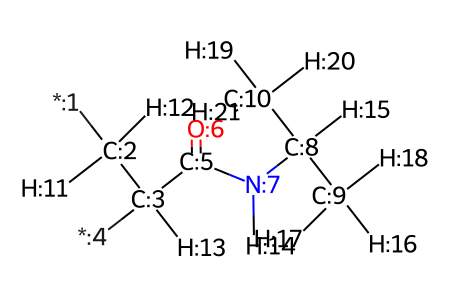

pnipaam_TERM1


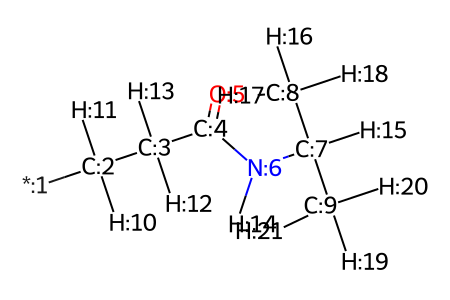

pnipaam_TERM2


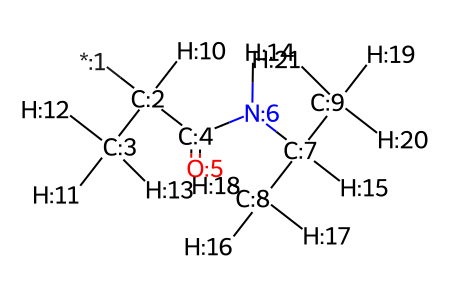

In [2]:
from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.polymers.monomers import MonomerGroup


fragment_file = assemble_path(EXAMPLE_DIR, 'PNIPAAm_fragments', extension='json')
assert fragment_file.exists()

monogrp = MonomerGroup.from_file(fragment_file)
for name, mol in monogrp.iter_rdmols():
    print(name)
    display(mol)

## 1) Reduction
Build an oligomer which is small enough to be charged with a semi-empirical method in a reasonable amount of time

In [3]:
import tempfile
from openff.toolkit import Molecule, Topology # this import might take a sec the first time you run this cell

from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb, mbmol_to_rdkit_pdb
from polymerist.mdtools.openfftools.topology import get_largest_offmol
from polymerist.mdtools.openfftools.partition import partition


def build_openff_polymer(monomers : MonomerGroup, n_monomers : int, **kwargs) -> Molecule:
    '''
    Helper function to aid this demo (and your polymer studies :P)

    Builds an OpenFF polymer Molecule whose atom metadata
    encodes a graph partition by custom residues
    '''
    # assign coordinates using mBuild backend, save to PDB file
    chain = build_linear_polymer(monomers=monomers, n_monomers=n_monomers, **kwargs)
    with tempfile.NamedTemporaryFile(dir=RCT_DIR, suffix='.pdb', delete=True) as pdb_temp: 
        logging.warning(pdb_temp.name)
        # mbmol_to_openmm_pdb(pdb_temp.name, chain)
        mbmol_to_rdkit_pdb(pdb_temp.name, chain) # need to write to PDB initially to perform partition via from_pdb() load
        offtop = Topology.from_pdb(pdb_temp.name, _custom_substructures=monomers.monomers)
        assert partition(offtop) # ensure a partition can be found from the passed fragments
        
    return get_largest_offmol(offtop) # extract molecule object and return

[18:28:07] WARNING: not removing hydrogen atom with dummy atom neighbors


In [4]:
from polymerist.polymers.estimation import estimate_n_monomers_infimum


n_atoms_max : int = 150 # this is a practical upper bound which balances accuracy vs speed of AM1-BCC
n_monomers : int = estimate_n_monomers_infimum(monogrp, n_atoms_max) # guarantees the resulting molecule is not bigger than the prescribed max  

oligomer : Molecule = build_openff_polymer(
    monogrp, 
    n_monomers=n_monomers,
    sequence='A', # linear homopolymer in the middle (end groups are implicit)
    energy_minimize=True, # UFF minimization helps avoid unphysical conformers for AM1-BCC    
)
oligomer.visualize(backend='nglview')

INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'pnipaam_TERM1', 'tail': 'pnipaam_TERM2'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "A" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 5 whole 1-sequence repeat(s), namely with the sequence [pnipaam_TERM1] + 5*[A] + [pnipaam_TERM2]
INFO:polymerist.polymers.building.linear:Registering middle monomer pnipaam_MIDDLE (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering terminal monomer pnipaam_TERM1 (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer pnipaam_TERM2 (orientation "tail")
INFO:polymerist.polymers.building.linear:Assembling linear 7-mer chain (estimated 135 atoms)
INFO:polymerist.polymers.building.linear:Successfully assembled linear 7-mer chain (exactly 135 atoms)
INFO:polymerist.polymers.building.linear:Energy-minimizing chain to fin

NGLWidget()

## 2) Charge
Assign partial charges with explicit method and generate library charge templates

You can opt for a "quick-and-dirty" charging method to get the gist of the approach, or go for full AM1-BCC ELF10 to get the fully experience; \
Just note that the latter will take a much longer time, especially depending on the complexity of the system!

In [5]:
from polymerist.mdtools.openfftools.topology import topology_to_sdf
from polymerist.mdtools.openfftools.partialcharge.molchargers import (
    NAGLCharger,  # requires having OpenFF NAGL installed
    ABE10Charger, # requires having OpenEye toolkits installed and licensed
)


quick_and_dirty : bool = True # whether to use full-blown AM1-BCC ELF10 or a quicker analogue just for proof-of-concept
oligomer_name : str = 'PNIPAAm_oligomer'

# assign partial charges
mol_charger = NAGLCharger() if quick_and_dirty else ABE10Charger()
oligomer_charged : Molecule = mol_charger.charge_molecule(oligomer)

logging.info(f'Recorded charge method: {oligomer_charged.properties["charge_method"]}')
logging.info(f'Net partial charge after charger: {oligomer_charged.partial_charges.sum()}')

# save charged oligomer to file for reference
cmol_path_sdf : Path = assemble_path(RCT_DIR, oligomer_name, postfix='reduced_charged', extension='sdf')
topology_to_sdf(cmol_path_sdf, oligomer_charged.to_topology()) # similarly, cache molecule with charges

INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Assigning partial charges via the "NAGL" method
INFO:openff.nagl.nn._models:Could not find property in lookup table: 'Could not find property value for molecule with InChI InChI=1/C42H79N7O7/c1-23(2)43-36(50)18-16-17-31(38(52)45-25(5)6)19-32(39(53)46-26(7)8)20-33(40(54)47-27(9)10)21-34(41(55)48-28(11)12)22-35(42(56)49-29(13)14)30(15)37(51)44-24(3)4/h23-35H,16-22H2,1-15H3,(H,43,50)(H,44,51)(H,45,52)(H,46,53)(H,47,54)(H,48,55)(H,49,56)/t30-,31+,32+,33+,34+,35+/m1/s1/f/h43-49H'
INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Successfully assigned "NAGL" charges
INFO:root:Recorded charge method: NAGL
INFO:root:Net partial charge after charger: 8.881784197001252e-16 elementary_charge


Extract and save library charges from partial charge and residue info on oligomer

In [6]:
from polymerist.mdtools.openfftools.partialcharge.rescharge.calculation import (
    compute_residue_charges,
    ChargesByResidue,
    UniformDistributionStrategy,
)

lib_charges : ChargesByResidue = compute_residue_charges(oligomer_charged, monogrp, cds=UniformDistributionStrategy())
lib_chg_path : Path = assemble_path(RCT_DIR, oligomer_name, postfix='library_charges', extension='json')
lib_charges.to_file(lib_chg_path)

INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Selected representative residue groups
INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Accumulated charges across all matching residues
INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Redistributing charges for residue "pnipaam_MIDDLE" according to UniformDistributionStrategy
INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Redistributing charges for residue "pnipaam_TERM1" according to UniformDistributionStrategy
INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Redistributing charges for residue "pnipaam_TERM2" according to UniformDistributionStrategy
INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Successfully computed library charges for Molecule ""


## 3) Transfer
Build a much larger molecule which will be charged using the library charged calculated during Reduction

In [7]:
DOP_polymer : int = 60 # NOTE that this is the total number of repeat units (NOT atoms) in the larger polymer
do_energy_minimization : bool = False
# do_energy_minimization : bool = True  # enabling Emin will make building take longer, but may give a more physical-looking structure


# build larger molecule - might take a second, depending on how big you've specified it to be
polymer_name : str = f'PNIPAAm_{DOP_polymer}-mer'
polymer = build_openff_polymer(
    monogrp, 
    n_monomers=DOP_polymer, # guarantees the resulting molecule is not bigger than the prescribed max  
    sequence='A', # linear homopolymer in the middle (end groups are implicit)
    energy_minimize=do_energy_minimization,
)
polymer.visualize(backend='nglview')

INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'pnipaam_TERM1', 'tail': 'pnipaam_TERM2'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "A" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 58 whole 1-sequence repeat(s), namely with the sequence [pnipaam_TERM1] + 58*[A] + [pnipaam_TERM2]
INFO:polymerist.polymers.building.linear:Registering middle monomer pnipaam_MIDDLE (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering terminal monomer pnipaam_TERM1 (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer pnipaam_TERM2 (orientation "tail")
INFO:polymerist.polymers.building.linear:Assembling linear 60-mer chain (estimated 1142 atoms)
INFO:polymerist.polymers.building.linear:Successfully assembled linear 60-mer chain (exactly 1142 atoms)


NGLWidget()

Load and assign library charges to the larger polymer

In [8]:
from polymerist.mdtools.openfftools.partialcharge.rescharge.interface import LibraryCharger


lib_charges = ChargesByResidue.from_file(lib_chg_path)
lib_charger = LibraryCharger(lib_charges)

polymer_charged = lib_charger.charge_molecule(polymer)
polymer_path_sdf : Path = assemble_path(RCT_DIR, polymer_name, postfix='RCT_charged', extension='sdf')
topology_to_sdf(polymer_path_sdf, polymer_charged.to_topology())

INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Assigning partial charges via the "RCT" method
INFO:polymerist.mdtools.openfftools.partialcharge.rescharge.calculation:Successfully mapped residue charges onto Molecule ""
INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Successfully assigned "RCT" charges


## That's all there is to it!